In [1]:
import os

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torch.utils.data as data

from torchvision.transforms.functional import erase
import torchvision.datasets.voc as voc

from PIL import Image
from random import seed
from random import random
from typing import Any, Callable, Optional, Tuple
import xml.etree.ElementTree as ET
import numpy as np
import json

from src.imagenet_utils.imagenet_utils import *


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def _add_bias(image, bias_method: str):
    _, W, H = image.size()
    if bias_method is None:
        return image
    elif 'pad' in bias_method:
        trans = transforms.Compose([
            transforms.CenterCrop(W-10),
            transforms.Pad(5)
        ])
        return trans(image)
    elif 'affine' in bias_method:
        return transforms.RandomAffine(10)(image)
    elif 'box' in bias_method:
        h = min([H, W]) // 3
        image = F.erase(image, i=0, j=0, h=h, w=h, v=0)
        return image

In [3]:
class BiasedPascalVOC_Dataset(voc.VOCDetection):
    def __init__(self,
                 root: str,
                 image_set: str,
                 biased_class: int = None,
                 bias_method: Optional[str] = None,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,
                 download: bool = False):
        super(BiasedPascalVOC_Dataset, self).__init__(root=root,
                                                      image_set=image_set,
                                                      transform=transform,
                                                      target_transform=target_transform,
                                                      download=download)

        self.biased_class = biased_class
        self.bias_method = bias_method

    def __getitem__(self, index):
        img, target = super(BiasedPascalVOC_Dataset, self).__getitem__(index)

        if self.biased_class is not None and self.biased_class in np.where(target == 1)[0]:
            img = _add_bias(img, self.bias_method)

        return img, target

In [4]:
def human_readable_voc_labels():
    """
    Create human readable VOC PASCAL lables. 
    idx2label[i] returns text label associated to class i.
    """
    with open('src/imagenet_utils/pascal_voc_class_index.json', 'rb') as f:
        class_idx = json.load(f)
    idx2label = [class_idx[str(k)] for k in range(len(class_idx))]
    return sorted(idx2label)

In [5]:
def _voc_pascal(biased_class: Optional[int] = None, bias_method: Optional[str] = None):
    VOC_MEAN, VOC_STDDEV = [102.9801/255, 115.9465/255, 122.7717/255], [0.229, 0.224, 0.225]
    VOC_PATH = 'nas/data/nesti_pacini/'

    normalize = transforms.Normalize(mean=VOC_MEAN, std=VOC_STDDEV)
    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        #     transforms.RandomResizedCrop(227),
        transforms.ToTensor(),
        normalize
    ])

    idx2label = human_readable_voc_labels()

    def transform_targets(x):
        list_obj = x['annotation']['object']
        names_obj = [ob['name'] for ob in list_obj]
        target = np.zeros(len(idx2label))
        for o in names_obj:
            target[idx2label.index(o.lower())] = 1

        return target

    transform_target = transforms.Lambda(transform_targets)

    # Using validation also for train for now. Too much time to load images.
    trainset = BiasedPascalVOC_Dataset(root='/nas/data/nesti_pacini/datasets/', download=False, image_set='trainval',
                                       transform=transform, target_transform=transform_target,
                                       biased_class=biased_class, bias_method=bias_method)
    testset = BiasedPascalVOC_Dataset(root='/nas/data/nesti_pacini/datasets/', download=False, image_set='val',
                                      transform=transform, target_transform=transform_target,
                                      biased_class=biased_class, bias_method=bias_method)
    return trainset, testset

In [6]:
trainset, testset = _voc_pascal(biased_class=19, bias_method='pad')

batch_size = 1
workers = 8

trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, sampler=None)

testloader = data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, sampler=None)

In [7]:
def print_lbls(labels):
    idx2label = human_readable_voc_labels()
    return [idx2label[index] for index in torch.nonzero(labels, as_tuple=True)[1]]

In [8]:
print(human_readable_voc_labels())

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


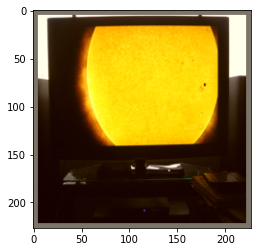

['tvmonitor']


In [9]:
dataiter = iter(testloader)

# Show example of image
images, labels = dataiter.next()

show_im(images, tensor=True)
print(print_lbls(labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


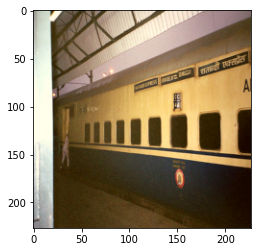

['person', 'train']


In [10]:
# Show example of image
images, labels = dataiter.next()

show_im(images, tensor=True)
print(print_lbls(labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


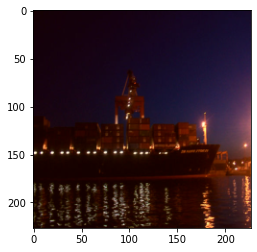

['boat']


In [11]:
# Show example of image
images, labels = dataiter.next()

show_im(images, tensor=True)
print(print_lbls(labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


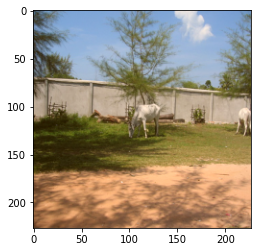

['cow']


In [12]:
# Show example of image
images, labels = dataiter.next()

show_im(images, tensor=True)
print(print_lbls(labels))